# Install and Import

In [ ]:
!pip install easyfsl

In [ ]:
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

## Setting seed

In [ ]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

## Train Data Loader

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms

batch_size = 64
n_workers = 2
image_size = 224
train_set = Flowers102(
    root="./data",
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

In [ ]:
train_set.get_labels = lambda: [
    (instance[1]-1) for instance in train_set
]

In [ ]:
print(f"Num of flower classes: {len(set(train_set.get_labels()))}")

Num of flower classes: 102


# Task sampling

In [ ]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.samplers import TaskSampler
n_way = 5
n_shot = 4
n_query = 6
n_validation_tasks = 100

val_set = Flowers102(
    root="./data",
    split = 'val',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)

## Validation sampler

In [ ]:

val_set.get_labels = lambda: [
    (instance[1]-1) for instance in val_set
]
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

# Convolutional Autoencoder (ConvAE)

In [ ]:
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, stride=1, padding=1),  # 
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
            torch.nn.Conv2d(64, 16, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=1, mode='nearest'),
            torch.nn.Conv2d(16, 64, 3, stride=1, padding=1),  # b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Upsample(scale_factor=1, mode='nearest'),
            torch.nn.Conv2d(64, 3, 3, stride=1, padding=2),  # b, 8, 3, 3
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        coded = self.encoder(x)
        decoded = self.decoder(coded)
        return decoded

In [ ]:
import matplotlib.pyplot as plt

## Training for Image Reconstruction



Please scroll to the bottom of the output to view the results of training using Loss vs Epochs Curve and comparison between the original images and reconstructed images


Convolutional AutoEncoder Network Model Set!

____________________________________________________

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=1.0, mode=nearest)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=1.0, mode=nearest)
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
)
____________________________________________________


Training the Convolutional AutoEncoder Model on Training Data...
----------------
Epoch: 1 | Loss:

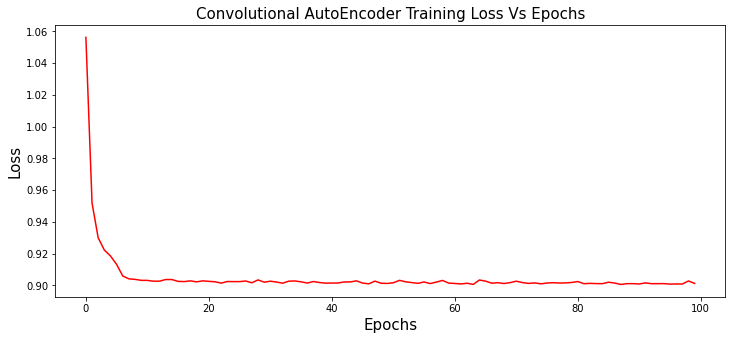


____________________________________________________

PRINTING ORIGINAL IMAGES THAT TRAINED THE MODEL AND THEIR RECONSTRUCTIONS ...


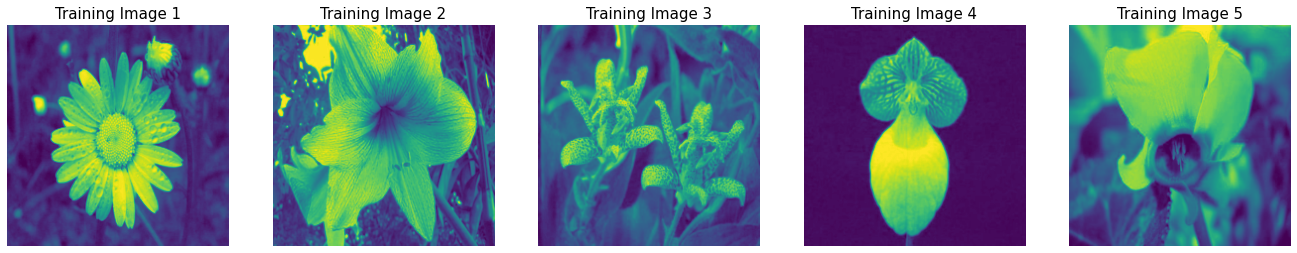

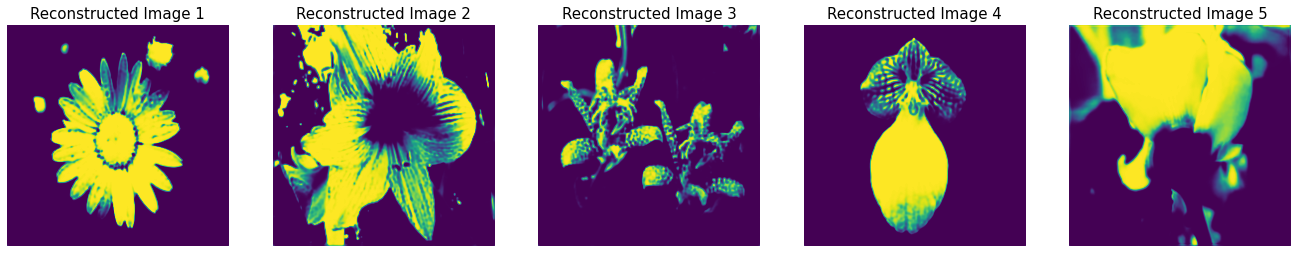

In [ ]:
print("\nConvolutional AutoEncoder Network Model Set!")

print("\n____________________________________________________\n")
learning_rate = 1e-2
weight_decay = 5e-4
epochs = 200
# defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# defining the model
convAE_model = ConvAutoencoder().to(device)

# defining the optimizer
optimizer = torch.optim.Adam(convAE_model.parameters(), lr= learning_rate, weight_decay= weight_decay)

# defining the loss function
loss_function = torch.nn.MSELoss().to(device)

print(convAE_model)
print("____________________________________________________\n")

print("\nTraining the Convolutional AutoEncoder Model on Training Data...")

# Training of Model

losses = []
for epoch in range(epochs): 
    epoch_loss = 0
    for X, y in train_loader:
        img = X.to(device)
        img = torch.autograd.Variable(img)
    
        recon = convAE_model(img)

        loss = loss_function(recon, img)
        
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+= loss
        print('-', end= "", flush= True)

    epoch_loss = epoch_loss/len(train_loader)
    losses.append(epoch_loss)

    print("\nEpoch: {} | Loss: {:.4f}".format(epoch+1, epoch_loss))

print("\n____________________________________________________\n")

fig = plt.figure(figsize = (12,5))
losses = [item.cpu().detach() for item in losses]
plt.plot(losses, '-r', label='Training loss')
plt.xlabel('Epochs', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.title('Convolutional AutoEncoder Training Loss Vs Epochs', fontsize= 15)
plt.show()

print("\n____________________________________________________\n")

print("PRINTING ORIGINAL IMAGES THAT TRAINED THE MODEL AND THEIR RECONSTRUCTIONS ...")

# Print Some Reconstructions
plt.figure(figsize = (23, 8))

start = 4
n_images = 5

for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(X[start+i+1][0])
    plt.title('Training Image ' + str(i+1), fontsize = 15)
    plt.axis("off")

plt.figure(figsize = (23, 8))

for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    pic = recon.cpu().data
    plt.imshow(pic[start+i+1][0])
    plt.title('Reconstructed Image ' + str(i+1), fontsize = 15)
    plt.axis("off")


## Saving the model

In [ ]:
PATH = '/kaggle/working/autoencoder'
torch.save(convAE_model.state_dict(),PATH)

# Episodic Training

In [ ]:
from easyfsl.methods import FewShotClassifier
k = 10

In [ ]:
import copy
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        print(z_support.shape)
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

cnn = copy.deepcopy(convAE_model)
cnn.decoder = nn.Flatten()
print(cnn)



ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
model = PrototypicalNetworks(cnn).to(device)

## Test Task Sampling

In [ ]:
test_set = Flowers102(
    root="./data",
    split = 'test',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


In [ ]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 4  # Number of images per class in the support set
N_QUERY = 6  # Number of images per class in the query set
N_EVALUATION_TASKS = 500

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [instance[1]-1 for instance in test_set]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    # model.process_support_set()
    return (
        torch.max(
            
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(val_loader)

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

Model tested on 100 tasks. Accuracy: 52.67%


In [ ]:
N_TRAINING_EPISODES = 20000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [ ]:
from torch import optim
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    # model.process_support_set()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(),
        query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Train the modelh this cell
from easyfsl.utils import sliding_average
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 1500/1500 [10:57<00:00,  2.28it/s, loss=2.66]


# Evaluating on the test dataset

In [ ]:
evaluate(test_loader)


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 53.33%


# Evaluating on the Validation Dataset

In [ ]:
evaluate(val_loader)

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]

Model tested on 100 tasks. Accuracy: 64.40%
